# Optimal feature clustering - Part II
> In Part II of this series, I will describe available metrics to determine distances between features, or variables. Together with Part I, this completes a framework for optimal feature clustering, which will be subject to controlled numerical experiments in Part III.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Clustering, Entropy, Membership Entropy, Feature Selection, Variation of Information, Correlation Distance]
- image: images/post_image_optimal_clustering.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

## Introduction

In [**Part I**](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/feature%20selection/variation%20of%20information/correlation%20distance/2021/02/12/optimal_feature_clustering_part_I.html) I described a general framework for optimal clustering based on information-theoretic arguments. The analysis conducted there was completely generic to any probabilistic clustering algorithm.

The purpose of this series of articles, however, is to describe optimal clustering of features. To do so, we need to be able to effectively calculate the distance between a pair of features, say $X$ and $Y$. This will be the subject of **Part II**.

## Distance metrics for feature comparison

Based on {% cite Prado2020 %}, let me briefly introduce three different metrics:

**1. Correlation distance (two-sided)**: $$ d_\rho (X, Y) = \sqrt{(1-\rho(X,Y))/2} $$

Here, $\rho(X,Y)$ is the correlation coefficient between $X$ and $Y$. This definition has the property that, if $X$ and $Y$ are perfectly anti-correlated the distance between them is maximal. On the other hand, if $\rho(X,Y) = 1 \implies d_\rho = 0$.

**2. Correlation distance (one-sided)**: $$ d_{\vert \rho \vert} = \sqrt{1 - \vert \rho(X,Y) \vert} $$

Depending on the application, we may want the property of zero distance for both perfect correlation and anti-correlation. This alternative definition satisfies that, besides setting a maximum distance between $X$ and $Y$ when they are completely uncorrelated.

**3. Variation of information**: $$d_I(X,Y) = 1 - \frac{I(X,Y)}{S(X,Y}$$

Both correlation-based metrics above share the same limitation. They are only well defined if the relationship between $X$ and $Y$ is linear or, equivalently, if they follow a bivariate normal distribution. I have discussed in a previous [post](https://joaodmrodrigues.github.io/elements-financial-machine-learning/information%20theory/mutual%20information/feature%20selection/feature%20importance/2021/02/06/mutal_information_and_feature_selection.html) how information-theoretic quantities allow us to measure a broader class of relations. In this context, we can define above entropy-based distance metric called *variation of information*. Here, $S(X,Y)$ and $I(X,Y)$ are the joint entropy and mutual information between $X$ and $Y$, respectively. In this framework, the distance between $X$ and $Y$ vanishes if and only if they are independent. Check out my previous [post](https://joaodmrodrigues.github.io/elements-financial-machine-learning/information%20theory/mutual%20information/feature%20selection/feature%20importance/2021/02/06/mutal_information_and_feature_selection.html) for a discussion and proper definition of entropy and mutual information. I will skip this step here.

All three quantities defined above are true metrics, in the sense that they satisfy all the properties required by a metric: non-negativity, symmetry and triangle inequality. They then allow the construction of a topological structure in this space of features. Besides, all three metrics are normalized, such that $0 \leq d \leq 1$.

Let's define some functions to calculate these metrics:

**1. Correlation distance (two-sided):**

In [1]:
def calculate_corr_distance_2side(X, Y):
    rho = np.corrcoef(np.array((X, Y)))[0,1]
    distance = np.sqrt((1-rho)/2)
    return distance

**2. Correlation distance (one-sided):**

In [2]:
def calculate_corr_distance_1side(X, Y):
    rho = np.corrcoef(np.array((X, Y)))[0,1]
    distance = np.sqrt(1-np.abs(rho))
    return distance

**3. Variation of information:**

In [3]:
#collapse-show
import numpy as np
def calculate_entropy(X):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram(X, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6    
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_joint_entropy(X, Y):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram2d(X, Y, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_mutual_information(X, Y):
    S_X = calculate_entropy(X)
    S_Y = calculate_entropy(Y)
    S_XY = calculate_joint_entropy(X, Y)
    I = S_X+S_Y-S_XY
    return I

def calculate_variation_of_information(X, Y):
    I = calculate_mutual_information(X, Y)
    S = calculate_joint_entropy(X, Y)
    distance = 1 - I/S
    
    return distance

## Numerical illustration

Let me now generate some sample datasets to illustrate the behaviour of the different metrics defined above.

### Linear relationships

I'll start by generating samples from a bivariate normal distribution for $(X,Y)$. We can construct correlated samples from uncorrelated ones by using the Cholesky decomposition, as implemented below:

In [4]:
#collapse-show
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

def generate_correlated_samples(N, rho):
    # The desired covariance matrix.
    r = np.array([[1.0, rho],
                 [rho, 1.0]])
    # Generate samples from 2 independent normally distributed N(0,1)
    x = norm.rvs(size=(2, N))
    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
    # Convert the data to correlated random variables. 
    y = np.dot(c, x)
    
    return (y[0,:], y[1,:])

Let's consider three cases of different correlation structure:

In [8]:
rhos = [0, 0.5, -0.95]
samples = [generate_correlated_samples(N=1000, rho=rho) for rho in rhos]

Let's now plot the datasets, together with the corresponding distances between $X$ and $Y$:

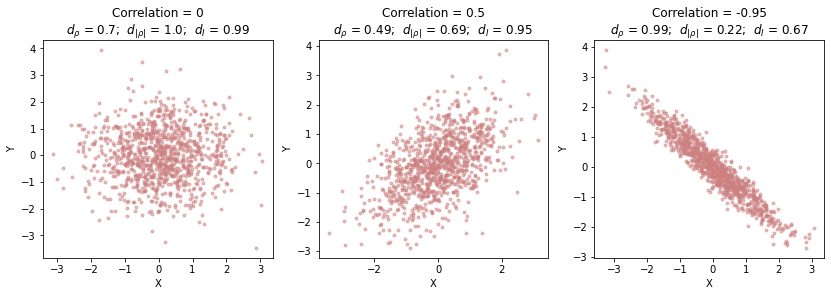

In [9]:
#collapse-hide
import matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, rho in enumerate(rhos):
    axes[i].plot(samples[i][0], samples[i][1], '.', color=(0.8,0.5,0.5,0.5))
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
    axes[i].set_title("Correlation = "+str(rho)+
                      "\n$d_\\rho$ = "+str(np.round(calculate_corr_distance_2side(samples[i][0], samples[i][1]),2))+
                      ";  $d_{\\vert \\rho \\vert}$ = "+str(np.round(calculate_corr_distance_1side(samples[i][0], samples[i][1]),2))+
                      ";  $d_I$ = "+str(np.round(calculate_variation_of_information(samples[i][0], samples[i][1]),2)))
plt.show()

**A few notes:**
- Case 1: As expected $d_{\vert \rho \vert}$ and $d_I$ estimate a distance close to 1 (maximum distance). Remember that, however, the two-sided correlation distance is defined such that $d_{\rho}=1$ when $X$ and $Y$ are perfectly uncorrelated.

- Case 2: All three metrics consider a smaller distance between $X$ and $Y$, consistent with the stronger correlation between them.

- Case 3: The two-side correlation distance is large, while the one-side correlation distance is small, because of the properties mentioned above. Variation of information is also smaller, because of the stronger relationship between $X$ and $Y$.

Finally, the different metrics seem to scale differently with respect to $\rho$. To better visualize this let's calculate all three metrics as we slowly increase the correlation coefficient from -1 to 1:

In [10]:
rhos = np.linspace(-1+1e-6, 1-1e-6, 200)
samples = [generate_correlated_samples(N=5000, rho=rho) for rho in rhos]

d_2side_rho = [calculate_corr_distance_2side(samples[i][0], samples[i][1]) for i in range(0, len(rhos))]
d_1side_rho = [calculate_corr_distance_1side(samples[i][0], samples[i][1]) for i in range(0, len(rhos))]
d_I         = [calculate_variation_of_information(samples[i][0], samples[i][1]) for i in range(0, len(rhos))]

Plotting the results:

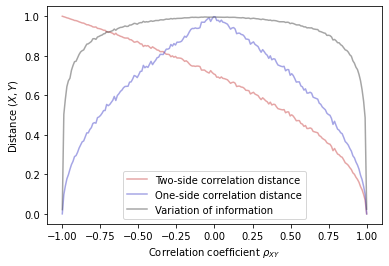

In [11]:
#collapse-hide
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(rhos, d_2side_rho, color=(0.8,0.3,0.3,0.5), label="Two-side correlation distance")
axes.plot(rhos, d_1side_rho, color=(0.3,0.3,0.8,0.5), label="One-side correlation distance")
axes.plot(rhos, d_I, color=(0.3,0.3,0.3,0.5), label="Variation of information")
axes.set_xlabel("Correlation coefficient $\\rho_{XY}$")
axes.set_ylabel("Distance $(X, Y)$")
axes.legend()
plt.show()

### Nonlinear relationships

Let's now consider a nonlinear relationship between $X$ and $Y$ in the form $Y=X^2 + \epsilon$, and generate a few samples of increasing amplitude in the noise term $\epsilon$:

In [12]:
noise = [0.1, 0.5, 2.0]

X = norm.rvs(size=(1, 1000))[0,:]

samples = list()
for value in noise:
    Y = X**2 + value*norm.rvs(size=(1, 1000))[0,:]
    Y = (Y-np.mean(Y))/np.std(Y)
    samples.append([X,Y])

And now plotting the results:

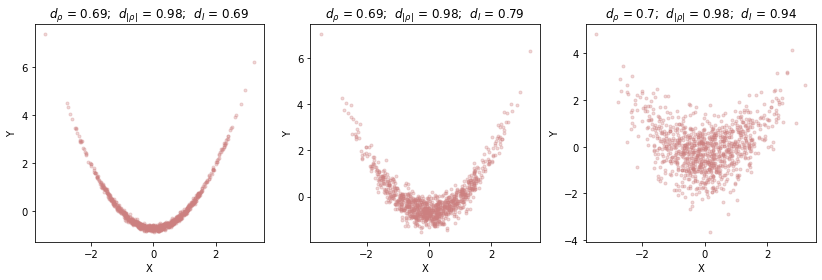

In [13]:
#collapse-hide
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, rho in enumerate(noise):
    axes[i].plot(samples[i][0], samples[i][1], '.', color=(0.8,0.5,0.5,0.3))
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
    axes[i].set_title("$d_\\rho$ = "+str(np.round(calculate_corr_distance_2side(samples[i][0], samples[i][1]),2))+
                      ";  $d_{\\vert \\rho \\vert}$ = "+str(np.round(calculate_corr_distance_1side(samples[i][0], samples[i][1]),2))+
                      ";  $d_I$ = "+str(np.round(calculate_variation_of_information(samples[i][0], samples[i][1]),2)))
plt.show()

As expected, correlation-based metrics fail in recognizing the degree of dependence between $X$ and $Y$ while variation of information does not. Note that, variation of information is still relatively high, even in the left case of low noise. This is partially because of the degeneracy in the variables. Knowing $Y$ does not uniquely determine $X$, even in the absence of noise.

Let's better visualize how all three metrics scale as we slowly increase the amplitude of the noise term. We begin by generating the samples:

In [20]:
noise = np.linspace(0, 2, 200)

X = norm.rvs(size=(1, 10000))[0,:]

samples = list()
for value in noise:
    Y = X**2 + value*norm.rvs(size=(1, 10000))[0,:]
    Y = (Y-np.mean(Y))/np.std(Y)
    samples.append([X,Y])

Now we calculate the different metrics:

In [21]:
d_2side_rho = [calculate_corr_distance_2side(samples[i][0], samples[i][1]) for i in range(0, len(noise))]
d_1side_rho = [calculate_corr_distance_1side(samples[i][0], samples[i][1]) for i in range(0, len(noise))]
d_I         = [calculate_variation_of_information(samples[i][0], samples[i][1]) for i in range(0, len(noise))]

And finally plot the results:

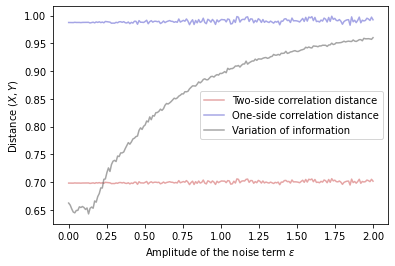

In [22]:
#collapse-hide
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.plot(noise, d_2side_rho, color=(0.8,0.3,0.3,0.5), label="Two-side correlation distance")
axes.plot(noise, d_1side_rho, color=(0.3,0.3,0.8,0.5), label="One-side correlation distance")
axes.plot(noise, d_I, color=(0.3,0.3,0.3,0.5), label="Variation of information")
axes.set_xlabel("Amplitude of the noise term $\epsilon$")
axes.set_ylabel("Distance $(X, Y)$")
axes.legend()
plt.show()

Clearly, because of the non-linear relationship between $X$ and $Y$, both correlation-based metric completely fail in describing their decreasing inter-dependence.

**Final notes:**

Now that we have described both 

1. An optimal clustering framework, in [**Part I**](https://joaodmrodrigues.github.io/elements-financial-machine-learning/clustering/entropy/membership%20entropy/feature%20selection/variation%20of%20information/correlation%20distance/2021/02/12/optimal_feature_clustering_part_I.html) of this series and;
2. Appropriate metrics to calculate the distance between pairs of features;

we can proceed to the final goal of performing optimal clustering of features. In the final **Part III** of this series, I will put all these ideas together and conduct several controlled numerical experiments to assess the performance of the entire framework.

**References:**

{% bibliography --cited %}